For this ML model, I am using yfinance for data on the daily time-frame.  
I have chosen 20 stocks from the NAS100, alongside QQQ and SPY. 

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
tickers = [
    'QQQ', 'AMZN', 'GOOG', 'AAPL', 'NVDA', 'CSCO', 'MSFT', 'PLTR', 
    'TSLA', 'META', 'IDXX', 'CSGP', 'KDP', 'NFLX', 'PEP', 'XEL', 
    'SPY', 'BKR', 'CTAS', 'DDOG', 'EXC', 'MELI', 'NXPI', 'STX'
]

raw_data = yf.download(tickers, start="2015-01-01", end="2025-12-01", group_by='ticker')

#restructuring to long format
prices = raw_data.stack(level=0)
prices.index.names = ['date', 'symbol']
prices.columns = [c.lower() for c in prices.columns] #rewrite column names in lowercase

print(prices.head())

[*********************100%***********************]  24 of 24 completed
C:\Users\rusty\AppData\Local\Temp\ipykernel_27236\1623972001.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  prices = raw_data.stack(level=0)


(63224, 5)


I will define 4 outcomes:  
1-day forward log return, calculated by the equation ln(Price(t+1)/Price(t)), where t = days. Log returns are better than simple returns in modeling because the effects are compoundable by the nature of logarithms.  
Next day sign of return (negative or positive)  
Cross-sectional rank of the 1 day return, calculated as a percent. 
5 day foward return

In [ ]:
def calculate_outcomes(prices):

    outcomes = pd.DataFrame(index=prices.index)
    outcomes["return_1"] = np.log((prices.groupby(level="symbol").close.shift(-1) / prices.groupby(level="symbol").close.shift(0)))
    outcomes["sign_1"] = np.sign(outcomes["return_1"])
    outcomes["rank_1"] = outcomes["return_1"].groupby(level="date").rank(pct = True, method = "first")
    # Calculate 5-day forward cumulative returns
    # This is usually much more 'predictable' than 1-day noise
    outcomes["return_5d_fwd"] = prices.groupby(level="symbol").close.transform(lambda x: (x.shift(-5) - x) / x)  # Simple return
    return outcomes

# Calculate outcomes for the original prices
outcomes = calculate_outcomes(prices)
outcomes.head(10)

return_1  sign_1    rank_1  return_5d_fwd
date       symbol                                           
2015-01-02 AAPL   -0.028576    -1.0  0.181818       0.024513
           AMZN   -0.020731    -1.0  0.272727      -0.037566
           BKR    -0.018145    -1.0  0.500000       0.005340
           CSCO   -0.020122    -1.0  0.318182       0.006519
           CSGP   -0.020075    -1.0  0.363636      -0.016266
           CTAS   -0.018397    -1.0  0.409091      -0.016954
           EXC    -0.028893    -1.0  0.136364      -0.028747
           GOOG   -0.021066    -1.0  0.227273      -0.054572
           IDXX   -0.006947    -1.0  0.909091       0.018055
           KDP    -0.003077    -1.0  1.000000       0.031425

Now I will create the features to train the model on. I decided to keep the feature names simple. 

In [ ]:

def calculate_all_features(prices):

    features = pd.DataFrame(index=prices.index)
    grp = prices.groupby(level='symbol').close


    for d in [1, 3, 5, 10]:l
        features[f'log_return_{d}d'] = -(prices.groupby(level='symbol')).close.transform(lambda x: np.log(x.shift(1)/ x.shift(d+1)))
    daily_log_ret = prices.groupby(level='symbol').close.transform(lambda x: np.log(x.shift(1) / x.shift(2)))

    for d in [5, 10, 20]:
        features[f'vol_{d}d'] = (daily_log_ret.groupby(level='symbol')
                                 .transform(lambda x: x.rolling(d+1).std()))
    features['mom_5d_vol_adj'] = -features['log_return_5d'] / features['vol_5d']
    features['mom_10d_vol_adj'] = -features['log_return_10d'] / features['vol_10d']

    daily_log_ret = -(prices.groupby(level='symbol').close
                     .transform(lambda x: np.log(x / x.shift(1))))

    spy_returns = daily_log_ret.xs('SPY', level='symbol')


    features['f_rel_str_spy'] = -(daily_log_ret.unstack(level='symbol')
                                 .sub(spy_returns, axis=0)
                                 .stack(level='symbol', future_stack=True))

    def calculate_rsi(series, period=14):
        delta = series.diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        ema_up = up.ewm(com=period - 1, adjust=False).mean()
        ema_down = down.ewm(com=period - 1, adjust=False).mean()
        rs = ema_up / ema_down
        return 100 - (100 / (1 + rs))

    features['f_rsi_14'] = -(prices.groupby(level='symbol').close
                            .transform(calculate_rsi))

    # Clean up
    features = features.dropna()
    return features

features = calculate_all_features(prices)
print(features[[ 'f_rel_str_spy', 'f_rsi_14']].tail())



                   f_rel_str_spy   f_rsi_14
date       symbol                          
2025-11-28 QQQ          0.002631 -56.276796
           SPY         -0.000000 -59.095036
           STX          0.010623 -59.169017
           TSLA         0.002937 -52.486210
           XEL          0.005085 -61.751642


Next we calculate the correlation between each feature and the outcome


                  mean_ic    ic_std        ir
vol_20d          0.025554  0.338581  0.075473
vol_10d          0.020425  0.328478  0.062182
vol_5d           0.018421  0.316966  0.058117
log_return_5d    0.017594  0.291152  0.060428
log_return_3d    0.010666  0.297097  0.035900
log_return_10d   0.008764  0.295654  0.029644
log_return_1d    0.007426  0.292468  0.025390
f_rsi_14         0.002478  0.282876  0.008761
f_rel_str_spy   -0.011120  0.289024 -0.038475
mom_10d_vol_adj -0.011419  0.274490 -0.041602
mom_5d_vol_adj  -0.014819  0.266742 -0.055556


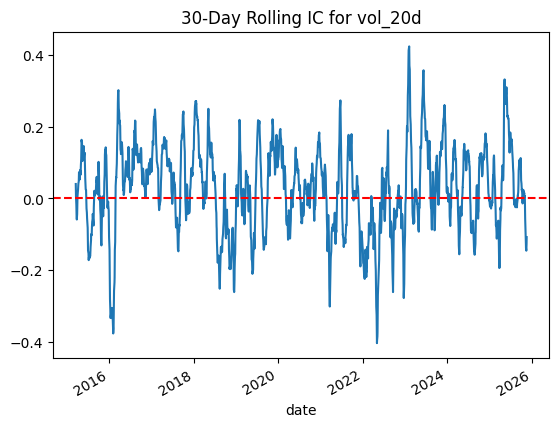

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
#define target
target = "return_5d_fwd"
combined = features.join(outcomes[target], how='inner').dropna()

feature_names = features.columns

daily_ic = (combined.groupby(level='date')
            .apply(lambda x: x[feature_names].corrwith(x[target], method='spearman')))

ic_summary = pd.DataFrame({
    'mean_ic': daily_ic.mean(),
    'ic_std': daily_ic.std(),
    'ir': daily_ic.mean() / daily_ic.std() 
}).sort_values('mean_ic', ascending=False)

print(ic_summary)
best_feature = ic_summary.index[0]
daily_ic[best_feature].rolling(30).mean().plot(title=f'30-Day Rolling IC for {best_feature}')
plt.axhline(0, color='red', linestyle='--')
plt.show()

We can see the features' correlation with eachother


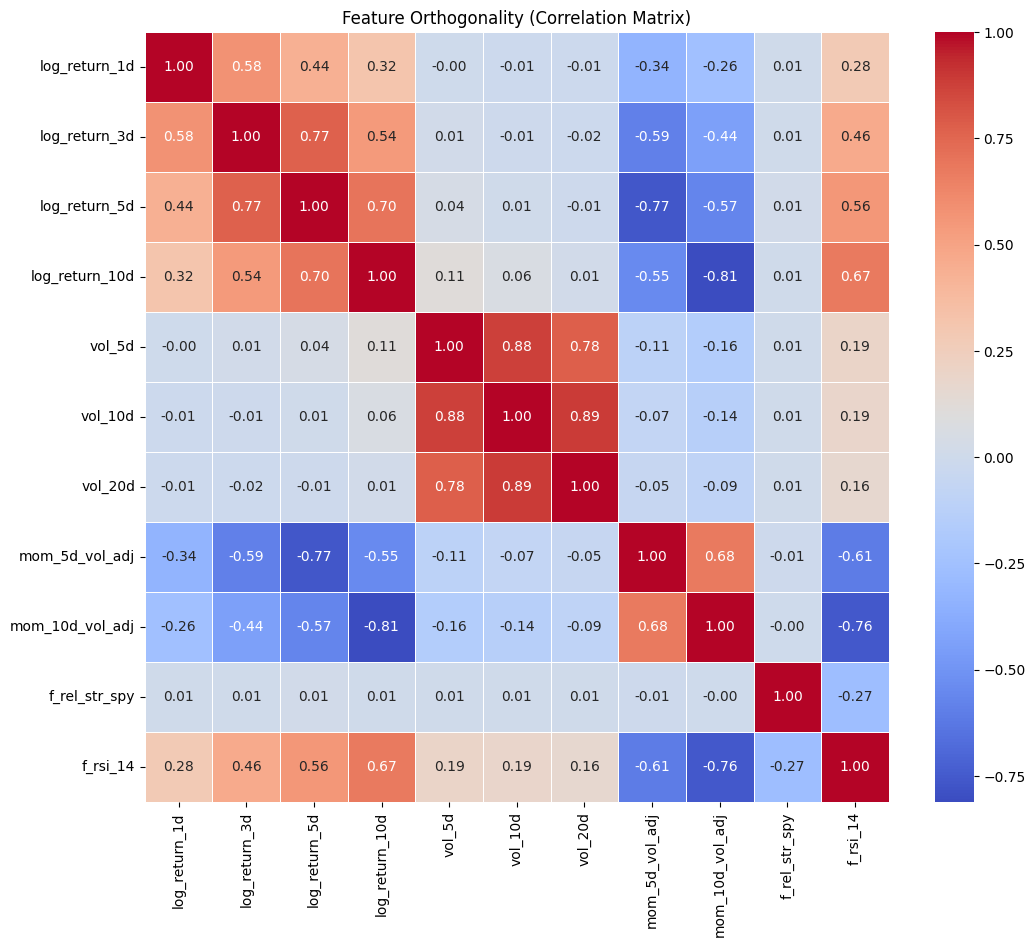

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_corr = features.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(feature_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Orthogonality (Correlation Matrix)")
plt.show()

In [ ]:
"Find features with IC>0.2 and corr < 0.7 with another feature"
combined = features.join(outcomes[target], how='inner')
feature_names = features.columns

daily_ic = (combined.groupby(level='date')
            .apply(lambda x: x[feature_names].corrwith(x[target], method='spearman')))
ic_summary = pd.DataFrame({
    'mean_ic': daily_ic.mean()
}).sort_values('mean_ic', ascending=False)


ic_filtered = ic_summary[ic_summary['mean_ic'].abs() > 0.01]
print(f"Features with IC > 0.02: {ic_filtered.index.tolist()}")

feature_corr_subset = features[ic_filtered.index].corr().abs()
selected_features = [ic_filtered.index[0]]


for feature in ic_filtered.index[1:]:

    max_corr = feature_corr_subset.loc[feature, selected_features].max()
    if max_corr < 0.7:
        selected_features.append(feature)
    else:
        print(f"Skipping {feature} (correlation {max_corr:.3f} > 0.7 with selected features)")

print(f"\nFinal selected features: {selected_features}")
features_selected = features[selected_features]


In [ ]:
features_selected.info()

outcomes[target].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 62696 entries, (Timestamp('2015-02-04 00:00:00'), 'AAPL') to (Timestamp('2025-11-28 00:00:00'), 'XEL')
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   log_return_5d    62696 non-null  float64
 1   mom_10d_vol_adj  62696 non-null  float64
 2   f_rel_str_spy    62696 non-null  float64
 3   vol_5d           62696 non-null  float64
dtypes: float64(4)
memory usage: 4.2+ MB
<class 'pandas.core.series.Series'>
MultiIndex: 63224 entries, (Timestamp('2015-01-02 00:00:00'), 'AAPL') to (Timestamp('2025-11-28 00:00:00'), 'XEL')
Series name: return_5d_fwd
Non-Null Count  Dtype  
--------------  -----  
63104 non-null  float64
dtypes: float64(1)
memory usage: 2.8+ MB


In [ ]:

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

date = features_selected.index.get_level_values('date').max()
X_exp = features_selected.xs(slice(None, date), level='date', drop_level=False)
y_exp = outcomes[target].reindex(X_exp.index)

valid_mask = ~(X_exp.isna().any(axis=1) | y_exp.isna())
X_train_exp = X_exp[valid_mask]
y_train_exp = y_exp[valid_mask]



model = LinearRegression()
model.fit(X=X_train_exp, y=y_train_exp)

in_sample_r2 = model.score(X=X_train_exp, y=y_train_exp)
train_preds = model.predict(X_train_exp)
signals = pd.Series(np.where(train_preds > 0, 1, -1), index=X_train_exp.index)
turnover = signals.groupby(level = 'symbol').diff().fillna(0).abs()
transaction_fees = (turnover * 0.001)
strategy_returns = signals * y_train_exp - transaction_fees

gross_profits = strategy_returns[strategy_returns > 0].sum()
gross_losses = abs(strategy_returns[strategy_returns < 0].sum())

in_sample_pf = gross_profits / gross_losses if gross_losses > 0 else np.nan
print(f"--- In-Sample Results until {date} ---")
print(f"R-squared: {round(in_sample_r2, 4)}")
print(f"Profit Factor: {round(in_sample_pf, 4)}")

--- In-Sample Results until 2025-11-28 00:00:00 ---
R-squared: 0.0046
Profit Factor: 1.3602


Expanding Window OOS RSQ: -0.0016
Rolling Window (6m) OOS RSQ: -0.0238
Expanding Window OOS IC: 0.0184


In [ ]:

def make_df(y_pred, y_true, fee_per_trade=0.001):
    y_pred.name = 'y_pred'
    y_true.name = 'y_true'
    
    df = pd.concat([y_pred, y_true], axis=1)

    df['sign_pred'] = df.y_pred.apply(np.sign)
    df['sign_true'] = df.y_true.apply(np.sign)
    
    "account for transcaion fees'
    df['turnover'] = (df.groupby(level='symbol')['sign_pred']
                      .diff()
                      .fillna(df['sign_pred'].abs())
                      .abs())
    
    df['transaction_costs'] = df['turnover'] * fee_per_trade
    # ------------------------------------

    df['is_correct'] = 0
    df.loc[df.sign_pred * df.sign_true > 0, 'is_correct'] = 1
    df['is_incorrect'] = 0
    df.loc[df.sign_pred * df.sign_true < 0, 'is_incorrect'] = 1
    df['is_predicted'] = df.is_correct + df.is_incorrect
    

    df['gross_result'] = df.sign_pred * df.y_true
    df['result'] = df['gross_result'] - df['transaction_costs']
    return df
#some metrics
def calc_scorecard(df):
    scorecard = pd.Series(dtype=float)
    
    scorecard.loc['accuracy'] = df.is_correct.sum() * 100. / df.is_predicted.sum() if df.is_predicted.sum() > 0 else 0
    scorecard.loc['net_edge'] = df.result.mean()
    scorecard.loc['gross_edge'] = df.gross_result.mean()
    scorecard.loc['fees_paid'] = df.transaction_costs.mean()

    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()
    scorecard.loc['y_true_chg'] = df.y_true.abs().mean()
    scorecard.loc['capture_ratio'] = scorecard.loc['net_edge'] / scorecard.loc['y_true_chg'] * 100

    net_profit = df[df.result > 0].result.sum()
    net_loss = abs(df[df.result < 0].result.sum())
    scorecard.loc['profit_factor'] = net_profit / net_loss if net_loss > 0 else 0
    
    return scorecard


FEE = 0.0005  

y_true = outcomes['return_5d_fwd']
common_idx = y_true.index.intersection(pred_exp.index)
mask_valid = ~(pred_exp.loc[common_idx].isna() | y_true.loc[common_idx].isna())

y_pred_all = pred_exp.loc[common_idx][mask_valid]
y_true_all = y_true.loc[common_idx][mask_valid]

df_all = make_df(y_pred_all, y_true_all, fee_per_trade=FEE)


overall_scorecard = calc_scorecard(df_all)
print(f"Overall Scorecard (All Stocks) - Fees: {FEE*100}% per side")
print(overall_scorecard)

def scorecard_by_symbol(df):
    return df.groupby(level='symbol').apply(calc_scorecard).T

symbol_scorecard = scorecard_by_symbol(df_all)
print("\nScorecard by Symbol (Net of Fees):")
print(symbol_scorecard)

Overall Scorecard (All Stocks) - Fees: 0.05% per side
accuracy         55.814927
net_edge          0.004638
gross_edge        0.004661
fees_paid         0.000023
noise             0.003322
y_true_chg        0.033738
capture_ratio    13.746400
profit_factor     1.318732
dtype: float64

Scorecard by Symbol (Net of Fees):
symbol              AAPL       AMZN        BKR       CSCO       CSGP  \
accuracy       56.888889  55.444444  51.971726  56.108429  53.629630   
net_edge        0.004275   0.003850   0.002607   0.002266   0.002581   
gross_edge      0.004305   0.003875   0.002625   0.002289   0.002605   
fees_paid       0.000030   0.000025   0.000018   0.000023   0.000024   
noise           0.000888   0.001001   0.001241   0.000794   0.000976   
y_true_chg      0.029255   0.033035   0.039969   0.023747   0.031576   
capture_ratio  14.611774  11.654298   6.523072   9.542885   8.174217   
profit_factor   1.342261   1.263825   1.139565   1.211017   1.178018   

symbol              CTAS      

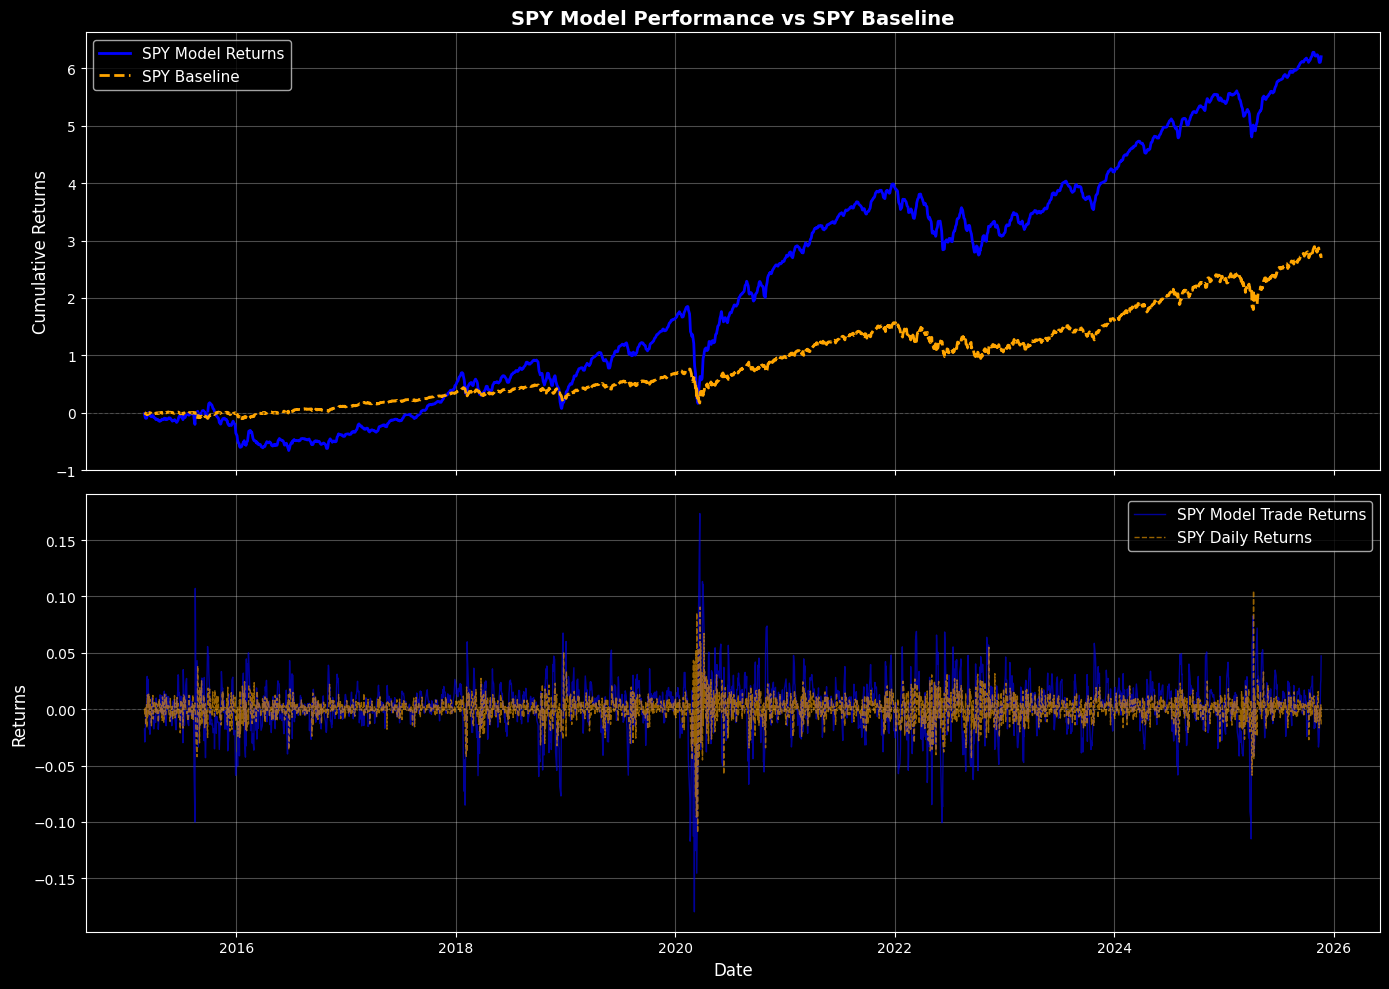


SPY Scorecard:
accuracy         59.207114
net_edge          0.002297
gross_edge        0.002326
fees_paid         0.000028
noise             0.000562
y_true_chg        0.016267
capture_ratio    14.123089
profit_factor     1.328801
dtype: float64

Final Cumulative Returns:
SPY Model: 6.2028 (620.28%)
SPY Baseline: 2.6959 (269.59%)
Excess Return: 3.5070 (350.70%)


In [ ]:

import matplotlib.pyplot as plt

stock_to_plot = 'SPY'

stock_mask = df_all.index.get_level_values('symbol') == stock_to_plot
df_stock = df_all[stock_mask].copy()

if len(df_stock) > 0:

    df_stock['cumulative_model_return'] = df_stock['result'].cumsum()
    
    spy_dates = df_stock.index.get_level_values('date')
    
    spy_mask = (prices.index.get_level_values('symbol') == 'SPY') & \
               (prices.index.get_level_values('date').isin(spy_dates))
    spy_prices_df = prices.loc[spy_mask, 'close'].sort_index()
    spy_daily_returns = spy_prices_df.groupby(level='symbol').pct_change()
    spy_daily_returns = spy_daily_returns.xs('SPY', level='symbol')
    

    spy_aligned = spy_daily_returns.reindex(spy_dates)
    spy_aligned = spy_aligned.fillna(0)  
    spy_cumulative = (1 + spy_aligned).cumprod() - 1
    
    spy_5d_returns = outcomes['return_5d_fwd'].xs('SPY', level='symbol')
    spy_5d_aligned = spy_5d_returns.reindex(spy_dates)
    spy_5d_aligned = spy_5d_aligned.fillna(0)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    ax1.plot(df_stock.index.get_level_values('date'), 
             df_stock['cumulative_model_return'], 
             label=f'{stock_to_plot} Model Returns', 
             linewidth=2, color='blue')
    ax1.plot(spy_dates, spy_cumulative, 
             label='SPY Baseline', 
             linewidth=2, color='orange', linestyle='--')
    ax1.axhline(0, color='black', linestyle=':', alpha=0.5)
    ax1.set_ylabel('Cumulative Returns', fontsize=12)
    ax1.set_title(f'{stock_to_plot} Model Performance vs SPY Baseline', fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(df_stock.index.get_level_values('date'), 
             df_stock['result'], 
             label=f'{stock_to_plot} Model Trade Returns', 
             alpha=0.6, color='blue', linewidth=1)
    ax2.plot(spy_dates, spy_aligned, 
             label='SPY Daily Returns', 
             alpha=0.6, color='orange', linewidth=1, linestyle='--')
    ax2.axhline(0, color='black', linestyle=':', alpha=0.5)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Returns', fontsize=12)
    ax2.legend(loc='best', fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    stock_scorecard = calc_scorecard(df_stock)
    print(f"\n{stock_to_plot} Scorecard:")
    print(stock_scorecard)
    
    final_model_return = df_stock['cumulative_model_return'].iloc[-1]
    final_spy_return = spy_cumulative.iloc[-1]
    print(f"\nFinal Cumulative Returns:")
    print(f"{stock_to_plot} Model: {final_model_return:.4f} ({final_model_return*100:.2f}%)")
    print(f"SPY Baseline: {final_spy_return:.4f} ({final_spy_return*100:.2f}%)")
    print(f"Excess Return: {(final_model_return - final_spy_return):.4f} ({(final_model_return - final_spy_return)*100:.2f}%)")
else:
    print(f"No data available for {stock_to_plot}")


In [ ]:
import numpy as np
import pandas as pd
from typing import List, Union

def get_permutation_with_volume(
    ohlcv: Union[pd.DataFrame, List[pd.DataFrame]], start_index: int = 0, seed=None
):

    assert start_index >= 0
    if seed is not None:
        np.random.seed(seed)

    if not isinstance(ohlcv, list):
        ohlcv = [ohlcv]
    
    n_markets = len(ohlcv)
    
    rel_data = {
        'start_bars': [], # Store log prices and volume
        'r_o': [], 'r_h': [], 'r_l': [], 'r_c': [], 'v': [],
        'time_indices': [], 'lengths': []
    }

    for mkt in ohlcv:
        log_bars = np.log(mkt[['open', 'high', 'low', 'close']])
        n_bars = len(mkt)
        p_idx = start_index + 1
        
        rel_data['time_indices'].append(mkt.index)
        rel_data['lengths'].append(n_bars)
        
        start_vals = np.zeros(5)
        start_vals[:4] = log_bars.iloc[start_index].to_numpy()
        start_vals[4] = mkt['volume'].iloc[start_index]
        rel_data['start_bars'].append(start_vals)

        rel_data['r_o'].append((log_bars['open'] - log_bars['close'].shift()).to_numpy()[p_idx:])
        rel_data['r_h'].append((log_bars['high'] - log_bars['open']).to_numpy()[p_idx:])
        rel_data['r_l'].append((log_bars['low'] - log_bars['open']).to_numpy()[p_idx:])
        rel_data['r_c'].append((log_bars['close'] - log_bars['open']).to_numpy()[p_idx:])
        rel_data['v'].append(mkt['volume'].to_numpy()[p_idx:])


    max_n = max(len(r) for r in rel_data['r_o'])
    master_idx = np.arange(max_n)
    

    p1 = np.random.permutation(master_idx)

    p2 = np.random.permutation(master_idx)

    perm_ohlcv_list = []
    for i in range(n_markets):
        m_len = len(rel_data['r_o'][i])
        
        m_p1 = p1[p1 < m_len]
        m_p2 = p2[p2 < m_len]
        
        shuffled_h = rel_data['r_h'][i][m_p1]
        shuffled_l = rel_data['r_l'][i][m_p1]
        shuffled_c = rel_data['r_c'][i][m_p1]
        shuffled_v = rel_data['v'][i][m_p1]
        shuffled_o = rel_data['r_o'][i][m_p2]

        n_bars = rel_data['lengths'][i]
        recon = np.zeros((n_bars, 5))
        
        orig_log = np.log(ohlcv[i][['open', 'high', 'low', 'close']]).to_numpy()
        orig_vol = ohlcv[i]['volume'].to_numpy()
        recon[:start_index, :4] = orig_log[:start_index]
        recon[:start_index, 4] = orig_vol[:start_index]
        recon[start_index] = rel_data['start_bars'][i]

        for b in range(start_index + 1, n_bars):
            k = b - (start_index + 1)
            recon[b, 0] = recon[b-1, 3] + shuffled_o[k] # new open
            recon[b, 1] = recon[b, 0] + shuffled_h[k]   # high
            recon[b, 2] = recon[b, 0] + shuffled_l[k]   # low
            recon[b, 3] = recon[b, 0] + shuffled_c[k]   # close
            recon[b, 4] = shuffled_v[k]                 # volume

        df = pd.DataFrame(recon, index=rel_data['time_indices'][i], 
                          columns=['open', 'high', 'low', 'close', 'volume'])
        df.iloc[:, :4] = np.exp(df.iloc[:, :4])
        perm_ohlcv_list.append(df)

    return perm_ohlcv_list if n_markets > 1 else perm_ohlcv_list[0]

P-Value below 0.05 shows that the model is learning patterns, not noise from these random permutations of data.

Starting MCPT with 100 iterations...
Using Fee: 0.1% per side
Real Net PF for comparison: 1.3602
1.3256727745737733
1.3462200909576327
1.3170362726332914
1.3165961492344371
1.3295446274005476
1.3357696213495387
1.3324440864233513
1.3030440021809353
1.3326785536151706
1.3198596625871377
Completed 10/100 (Last Rand PF: 1.3199)
1.3356047627449399
1.3235016091588063
1.3354713298874288
1.334297002315478
1.3317982604656808
1.309558526715177
1.322471641071921
1.3158739879779382
1.332619626164614
1.3361518793769676
Completed 20/100 (Last Rand PF: 1.3362)
1.3166081399359848
1.3294074636323767
1.319524016236964
1.3325375801610342
1.3326268122079985
1.3300009878454024
1.3523031767465392
1.3271750928827346
1.322350640836825
1.3331909782838192
Completed 30/100 (Last Rand PF: 1.3332)
1.3263336009843718
1.3196582438196343
1.337374213153244
1.3379172976795344
1.3367054931369826
1.321753251973023
1.3261674535950139
1.3292792232010102
1.3338108310616852
1.3300476429582913
Completed 40/100 (Last Rand PF:

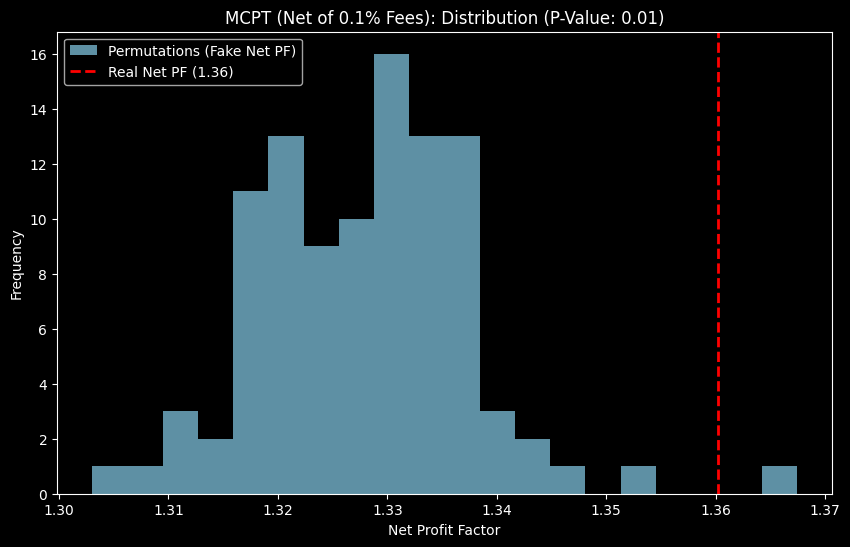

In [ ]:

import matplotlib.pyplot as plt


fee_per_trade = 0.001  
n_iterations = 100
target = 'return_5d_fwd' 
symbols = prices.index.get_level_values('symbol').unique()
prices_list = [prices.xs(s, level='symbol') for s in symbols]
mcpt_results = []

print(f"Starting MCPT with {n_iterations} iterations...")
print(f"Using Fee: {fee_per_trade*100}% per side")
print(f"Real Net PF for comparison: {in_sample_pf:.4f}")

for i in range(n_iterations):

    permuted_prices_list = get_permutation_with_volume(prices_list)
    

    perm_prices = pd.concat(permuted_prices_list, keys=symbols, names=['symbol', 'date']).swaplevel().sort_index()
    
    perm_features = calculate_all_features(perm_prices) 
    perm_outcomes = calculate_outcomes(perm_prices)
    

    data = pd.concat([perm_features, perm_outcomes[target]], axis=1).dropna()
    X = data[perm_features.columns]
    y = data[target]
    

    model = LinearRegression().fit(X, y)
    preds = model.predict(X)
    
    signals = pd.Series(np.where(preds > 0, 1, -1), index=X.index)
    
    turnover = (signals.groupby(level='symbol', group_keys=False)
                .diff()
                .fillna(signals.abs()) 
                .abs())
    
    net_returns = (signals * y) - (turnover * fee_per_trade)
    
    gross_profits = net_returns[net_returns > 0].sum()
    gross_losses = abs(net_returns[net_returns < 0].sum())
    
    pf = gross_profits / gross_losses if gross_losses > 0 else 0
    mcpt_results.append(pf)
    print(pf)
    # ---------------------------------

    if (i+1) % 10 == 0: 
        print(f"Completed {i+1}/{n_iterations} (Last Rand PF: {pf:.4f})")


p_value = np.sum(np.array(mcpt_results) >= in_sample_pf) / n_iterations

print(f"\nMCPT Finished. P-Value: {p_value}")

plt.style.use('dark_background')
plt.figure(figsize=(10, 6))
pd.Series(mcpt_results).hist(bins=20, alpha=0.7, color='skyblue', label='Permutations (Fake Net PF)')
plt.axvline(in_sample_pf, color='red', linestyle='--', linewidth=2, label=f'Real Net PF ({in_sample_pf:.2f})')
plt.xlabel("Net Profit Factor")
plt.ylabel("Frequency")
plt.title(f"MCPT (Net of {fee_per_trade*100}% Fees): Distribution (P-Value: {p_value})")
plt.grid(False)
plt.legend()
plt.show()

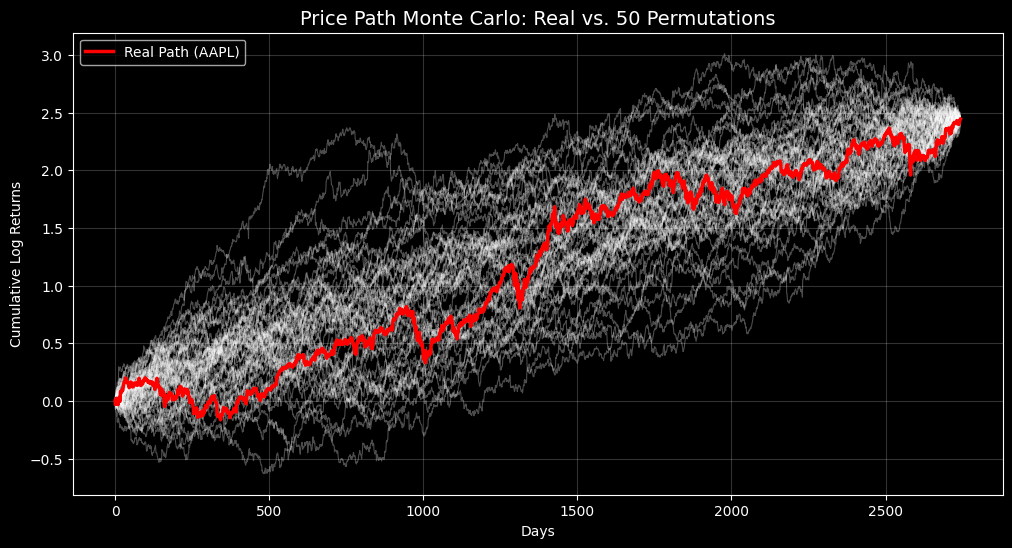

In [ ]:
import matplotlib.pyplot as plt

target_symbol = symbols[0] 
num_paths = 50 
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))

real_df = prices.xs(target_symbol, level='symbol')
real_log_returns = np.log(real_df.close / real_df.close.shift(1)).fillna(0)
real_cum_ret = real_log_returns.cumsum()

plt.plot(real_cum_ret.values, color='red', linewidth=2.5, label=f'Real Path ({target_symbol})', zorder=10)

for i in range(num_paths):

    perm_list = get_permutation_with_volume(prices_list)
    

    perm_df = perm_list[0] 
    

    perm_log_returns = np.log(perm_df.close / perm_df.close.shift(1)).fillna(0)
    perm_cum_ret = perm_log_returns.cumsum()
    
    plt.plot(perm_cum_ret.values, color='white', alpha=0.3, linewidth=0.8)

plt.title(f"Price Path Monte Carlo: Real vs. {num_paths} Permutations", fontsize=14)
plt.xlabel("Days")
plt.ylabel("Cumulative Log Returns")
plt.legend()
plt.grid(alpha=0.2)
plt.show()